In [1]:
import everest
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

## Load the light curve
Choose from 201367065 205071984, 201546283, 210957318, 211916756, 201546283

In [2]:
star = everest.Everest(201367065)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201367065.


## Plot the raw light curve

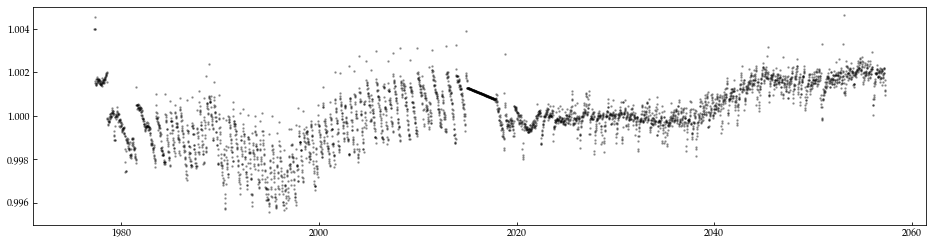

In [3]:
fig = pl.figure(figsize=(16,4))
pl.plot(star.time, star.fraw / np.nanmedian(star.fraw), 'k.', alpha = 0.3, ms = 3);
pl.ylim(0.995,1.005);

## Remove the really bad outliers and normalize

In [4]:
cut = np.where((star.fraw < 0.995) | (star.time < 1980))
time = np.delete(star.time, cut)
fpix = np.delete(star.fpix, cut, axis = 0)
ntime, npix = fpix.shape
fpix /= np.nanmedian(np.nansum(fpix, axis=1))
y = np.sum(fpix, axis = 1).reshape(-1, 1)

## The PLD design matrix

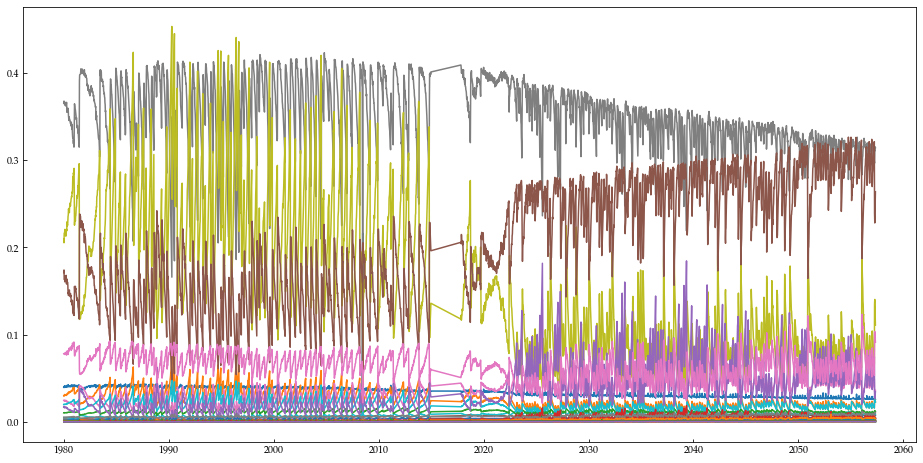

In [5]:
# PLD regressors
A = fpix / y.reshape(-1, 1)
fig = pl.figure(figsize=(16,8))
for n in range(npix):
  pl.plot(time, A[:,n]);

## The rotation covariance matrix (not optimized!)

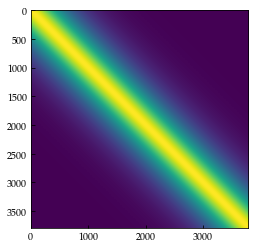

In [45]:
import george
K = george.GP(0.0001 ** 2 * george.kernels.Matern32Kernel(10. ** 2)).get_matrix(time)
pl.imshow(K);

## The diagonal regularization matrix (not optimized!)

In [49]:
L_diag = np.ones(A.shape[1]) * 0.005

## The full covariance

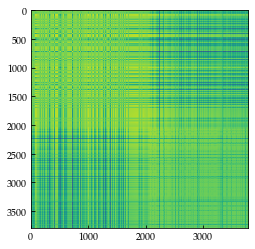

In [50]:
S = np.dot(A, L_diag[:, None] * A.T) + K
pl.imshow(S);

## The log likelihood

In [51]:
from scipy.linalg import cho_solve, cho_factor
choS = cho_factor(S)
def logL(model):
    return -0.5 * np.dot((y - model).reshape(1,-1), cho_solve(choS, y - model))

## Likelihood for a simple box transit at every point

In [52]:
from tqdm import tqdm
lnL0 = logL(0)[0][0]
dchisq = np.zeros_like(time)
for i in tqdm(range(2, len(time) - 2)):
    model = np.zeros_like(time)
    model[i-2:i+2] = -1
    model = model.reshape(-1, 1)
    varw = 1. / np.dot(model.reshape(1, -1), cho_solve(choS, model))
    w = varw * np.dot(model.reshape(1, -1), cho_solve(choS, y))
    r = y - w * model
    lnL = -0.5 * np.dot(r.reshape(1, -1), cho_solve(choS, r))
    dchisq[i] = -2 * (lnL0 - lnL)

100%|██████████| 3782/3782 [05:36<00:00, 12.13it/s]


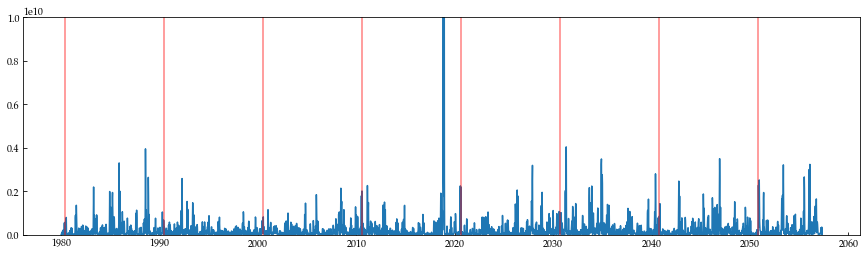

In [59]:
# Plot dchisq w/ planet b highlighted
fig, ax = pl.subplots(1, figsize=(15, 4))
pl.plot(time, dchisq);
pl.ylim(0, 1e10);
for i in range(8):
    pl.axvline(1980.4173 + i * 10.0545, color='r', alpha=0.5)

## Not great, but given that we didn't optimize any of our matrices, it's not a bad start.